# Final Model Training

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import os
import random
import cv2
import re
from sklearn.metrics import classification_report
import pandas as pd
from finetuning_functions import training_plots, dice_coefficient, Unet, plot_validation_masks, make_augmentations, combine_masks, numerical_sort, DataLoader
from pretraining_functions import unet_mod, Unet_encoder, BarlowTwins, resnet50_encoder
from sklearn.model_selection import KFold
from tqdm import tqdm

2023-12-21 15:23:10.846060: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 15:23:10.883554: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 15:23:10.883580: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 15:23:10.883613: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 15:23:10.891773: I tensorflow/core/platform/cpu_feature_g

In [2]:
# Model parameters

input_size = (512,512)
batch_size = 16
val_batch_size = 16
random.seed(42)
epochs =15
lr = 0.00001
drop = 0.3
model_path = os.path.join("..", "..", "..", "media", "FS2","models")

In [3]:
# Load data

labeled_data_dir = os.path.join("..", "..", "..", "media", "FS2", "data", "updated_masks")
masked_images = [0 for i in range(150)]
smoke_masks = [0 for i in range(150)] 
cloud_masks =[0 for i in range(150)]
image_nos = []


In [4]:
# loading masks
for subdir, dirs, files in os.walk(labeled_data_dir):
    for file in files:
        file_path = os.path.join(labeled_data_dir, file)
        mask = np.load(os.path.join(labeled_data_dir, file))
        image_no = int(file.split("-")[1])-1
        image_nos.append(image_no)
        if "Smoke" in file_path and not "cloud" in file:
            smoke_masks[image_no] = mask
        if "cloud" in file:
            cloud_masks[image_no] = mask

In [5]:
# correcting masks
for i in range(len(smoke_masks)):
    if np.shape(cloud_masks[i]) == ():
        blank_img = np.zeros(smoke_masks[i].shape,dtype=np.uint8)
        cloud_masks[i] = blank_img
    if np.shape(smoke_masks[i]) == ():
        blank_img = np.zeros(cloud_masks[i].shape,dtype=np.uint8)
        smoke_masks[i] = blank_img

assert(len(smoke_masks) == len(cloud_masks))

In [6]:
# storing masks
masked_images = combine_masks(smoke_masks, cloud_masks)

In [7]:
# loading images
originals = []
original_image_dir = os.path.join("..", "..", "..", "media", "FS2", "data", "updated_images")
for subdir, dirs, files in os.walk(original_image_dir):
    for file in sorted(files, key=numerical_sort):
        image = Image.open(os.path.join(original_image_dir, file)).convert('RGB')
        np_original = np.asarray(image)
        originals.append(np_original)
originals = originals[:150]

assert(len(originals) == len(masked_images))

In [8]:
# preparing data
dataset = DataLoader(masked_images, originals, target_shape=input_size)
inputs, targets = dataset.data_generator(150)

2023-12-21 15:23:14.264292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14757 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:d5:00.0, compute capability: 7.5


In [9]:
# define validation set - prevent data leakage in model training
random.seed(42)
val_inds = random.sample([i for i in range(150)], 25)
val_inputs = [inputs[ind] for ind in val_inds]
val_targets = [targets[ind] for ind in val_inds]
inputs = [inputs[ind] for ind in range(150) if ind not in val_inds]
targets = [targets[ind] for ind in range(150) if ind not in val_inds]


In [10]:
# Model functions
# Callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

# model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
#     "models/smoke_segmentation_256.h5", # update....
#     monitor="val_loss",
#     verbose=0,
#     save_best_only=True,
#     save_weights_only=False,
#     mode="auto",
#     save_freq="epoch",
# )

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=1e-7,
)

In [11]:
# augmentations on train
train_inputs, train_labels = inputs, targets
train_inputs, train_labels = make_augmentations(train_inputs, train_labels)
fold_val = tf.data.Dataset.from_tensor_slices((val_inputs, val_targets))
fold_train = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels))
train_batches = fold_train.batch(batch_size)
val_batches = fold_val.batch(val_batch_size)

In [12]:
# set up unet
input = tf.keras.layers.Input(shape=(input_size[0], input_size[1], 3))
optimizer = tf.keras.optimizers.SGD()
encoder = Unet_encoder(input)
barlow_twins = BarlowTwins(encoder)
barlow_twins.compile(optimizer=optimizer)
barlow_twins.encoder.load_weights(os.path.join(model_path, "barlow_twins_UNET"))
backbone = tf.keras.Model( barlow_twins.encoder.input, barlow_twins.encoder.layers[-2].output)
backbone.trainable = True
skip_layers = [backbone.get_layer(index=6).output,
backbone.get_layer(index=14).output,
backbone.get_layer(index=22).output,
backbone.get_layer(index=30).output]
unet = unet_mod(backbone, skip_layers, input, num_filters=16, kernel=3, dropout=drop, batch_norm=True, train_encoder=True)
unet.summary()

2023-12-21 15:23:23.791770: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open ../../../media/FS2/models/barlow_twins_UNET: FAILED_PRECONDITION: ../../../media/FS2/models/barlow_twins_UNET; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 16)         0         ['batch_normalization[0]

In [13]:
unet.compile(
            loss="sparse_categorical_crossentropy", 
            optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
            metrics=["accuracy", 
                    tf.keras.metrics.MeanIoU(num_classes=3, sparse_y_true=True, sparse_y_pred=False)]
                    )

In [14]:
# train
history = unet.fit(
train_batches,
validation_data=val_batches,
batch_size=batch_size,
epochs=epochs, 
callbacks=[
    early_stop_cb, 
    # model_ckpt_cb, 
    reduce_lr_cb
])

Epoch 1/15


2023-12-21 15:23:28.196254: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-21 15:23:28.930166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-21 15:23:32.978292: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f32fc291400 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-21 15:23:32.978353: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2023-12-21 15:23:32.993326: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-21 15:23:33.162849: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluste

125/125 [==============================] - 96s 617ms/step - loss: 1.5916 - accuracy: 0.2000 - mean_io_u: 0.1133 - val_loss: 1.2122 - val_accuracy: 0.2717 - val_mean_io_u: 0.1335 - lr: 1.0000e-05
Epoch 2/15
125/125 [==============================] - 75s 598ms/step - loss: 1.3426 - accuracy: 0.2331 - mean_io_u: 0.1327 - val_loss: 1.1587 - val_accuracy: 0.3305 - val_mean_io_u: 0.1743 - lr: 1.0000e-05
Epoch 3/15
125/125 [==============================] - 75s 600ms/step - loss: 1.1653 - accuracy: 0.2891 - mean_io_u: 0.1686 - val_loss: 1.0523 - val_accuracy: 0.4295 - val_mean_io_u: 0.2495 - lr: 1.0000e-05
Epoch 4/15
125/125 [==============================] - 75s 601ms/step - loss: 1.0680 - accuracy: 0.3739 - mean_io_u: 0.2279 - val_loss: 0.9757 - val_accuracy: 0.5451 - val_mean_io_u: 0.3465 - lr: 1.0000e-05
Epoch 5/15
125/125 [==============================] - 75s 601ms/step - loss: 1.0025 - accuracy: 0.4837 - mean_io_u: 0.3090 - val_loss: 0.9209 - val_accuracy: 0.6260 - val_mean_io_u: 0.418

In [15]:
def training_plots(history):
    fig, axs = plt.subplots(ncols=3, figsize=(12,3))
    # # Learning Rate
    # axs[0].plot(history.history['lr'])
    # axs[0].set_title('Learning Rate')
    # axs[0].set_xlabel("Epochs")
    # axs[0].set_ylabel("LR Value")

    # Loss Curves
    axs[0].plot(history.history['loss'], label="Train Loss")
    axs[0].plot(history.history['val_loss'], label="Train Loss")
    axs[0].set_title('Loss Curves')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")

    # Accuracy Curves
    axs[1].plot(history.history['accuracy'], label="Train")
    axs[1].plot(history.history['val_accuracy'], label="Test")
    axs[1].set_title('Accuracy Curves')
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Score")
    axs[1].legend()
    

    # IoU Curves
    axs[2].plot(history.history['mean_io_u'], label="Train")
    axs[2].plot(history.history['val_mean_io_u'], label="Test")
    axs[2].set_title('IoU Curves')
    axs[2].set_xlabel("Epochs")
    axs[2].set_ylabel("IoU")
    axs[2].legend()
    plt.savefig("training_plots_val.pdf")
    plt.show()
    

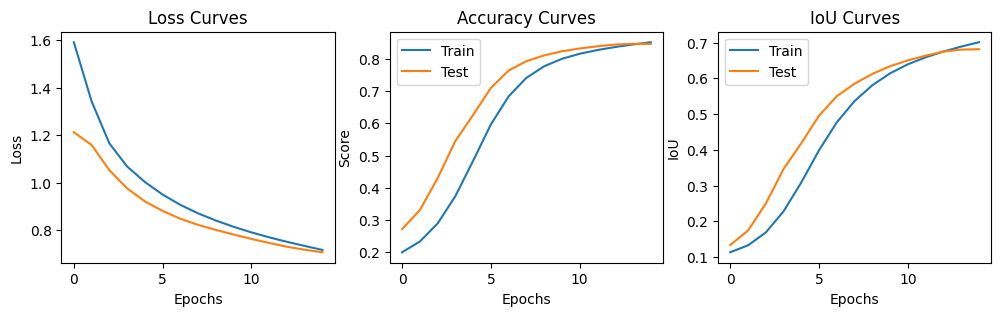

<Figure size 640x480 with 0 Axes>

In [16]:
training_plots(history)

In [17]:
images, labels = tuple(zip(*fold_val))
preds = unet.predict(val_batches)
pred_mask = tf.argmax(preds, axis=-1) 
m = tf.keras.metrics.MeanIoU(num_classes=3)
m.update_state(labels, pred_mask)
m.result().numpy()

2/2 [==============================] - 0s 109ms/step


0.681614

In [18]:
print(classification_report(np.array(labels).flatten(), np.array(pred_mask).flatten()))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91   3650286
           1       0.61      0.76      0.68    979478
           2       0.84      0.80      0.82   1923836

    accuracy                           0.85   6553600
   macro avg       0.79      0.82      0.80   6553600
weighted avg       0.86      0.85      0.85   6553600



In [19]:
unet.save(os.path.join(model_path, "final_BT_unet_val.h5"))
unet.save(os.path.join(model_path, "final_BT_unet_val.keras"))
unet.save(os.path.join(model_path, "final_BT_unet_pb_val"))

/home/sandrade/miniconda3/envs/odin/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: ../../../media/FS2/models/final_BT_unet_pb_val/assets


INFO:tensorflow:Assets written to: ../../../media/FS2/models/final_BT_unet_pb_val/assets


In [21]:
# convert to onnx
!python -m tf2onnx.convert \
    --saved-model {os.path.join(model_path, "final_BT_unet_pb_val")} \
    --output  {os.path.join(model_path, "final_BT_unet_val.onnx")}

2023-12-21 15:44:24.192130: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-21 15:44:24.228845: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 15:44:24.228879: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 15:44:24.228913: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 15:44:24.235806: I tensorflow/core/platform/cpu_feature_g